In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import numpy as np
import math
from scipy.signal import convolve2d 
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import random

In [2]:
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor
print("Số GPU có sẵn: ", len(tf.config.experimental.list_physical_devices('GPU')))

2025-04-25 08:14:42.131565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745568882.157434      91 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745568882.165121      91 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Số GPU có sẵn:  2


In [3]:
def rgb2gray(image: np.ndarray):
    gray_conversion_weights = np.array([0.29893602, 0.58704307, 0.11402090], dtype=np.float32)
    weighted_vector = gray_conversion_weights.reshape((3, 1))

    if image.ndim == 2:
        grayscale_image = image.astype(np.float32)
    elif image.ndim == 3:
        num_channels = image.shape[2]
        if num_channels == 1:
            grayscale_image = image[:, :, 0].astype(np.float32)
        elif num_channels == 3:
            height, width = image.shape[:2]
            pixels = image.reshape((height * width, 3))
            grayscale_values = np.dot(pixels, weighted_vector)
            grayscale_image = grayscale_values.reshape((height, width))
        elif num_channels == 4: 
            image = image[:, :, :3]
            height, width = image.shape[:2]
            pixels = image.reshape((height * width, 3))
            grayscale_values = np.dot(pixels, weighted_vector)
            grayscale_image = grayscale_values.reshape((height, width))
        else:
            raise ValueError('Phải là ảnh xám hoặc ảnh màu')
    else:
        raise ValueError('Phải là ảnh xám hoặc ảnh màu')

    return grayscale_image.astype(np.float32)


In [4]:
# @tf.function
# def rgb2gray(image: tf.Tensor):
#     gray_conversion_weights = tf.constant([0.29893602, 0.58704307, 0.11402090], dtype=tf.float32)
#     weighted_vector = tf.reshape(gray_conversion_weights, (3, 1))

#     image_rank = tf.rank(image)
    
#     if image_rank == 2:
#         grayscale_image = tf.cast(image, dtype = tf.float32)
#     elif image_rank == 3:
#         num_channels = tf.shape(image)[-1]
#         if num_channels == 1:
#             grayscale_image = tf.cast(tf.squeeze(image, axis=-1), dtype=tf.float32)
#         elif num_channels == 3:
#             height = tf.shape(image)[0]
#             width = tf.shape(image)[1]
#             pixels = tf.reshape(tf.cast(image, dtype=tf.float32), (height * width, 3))
#             grayscale_values = tf.matmul(pixels, weighted_vector)
#             grayscale_image = tf.reshape(grayscale_values, (height, width))
#         elif num_channels == 4: 
#             image_rgb = image[:, :, :3]
#             height = tf.shape(image_rgb)[0]
#             width = tf.shape(image_rgb)[1]
#             pixels = tf.reshape(tf.cast(image_rgb, dtype=tf.float32), (height * width, 3))
#             grayscale_values = tf.matmul(pixels, weighted_vector)
#             grayscale_image = tf.reshape(grayscale_values, (height, width))
#         else:
#             raise ValueError('Phải là ảnh xám hoặc ảnh màu')
#     else:
#         raise ValueError('Phải là ảnh xám hoặc ảnh màu')

#     return tf.cast(grayscale_image, dtype=tf.float32)



In [5]:
def generate_gaussian_kernel( sigma, ksize=None):
    if ksize is None:
        ksize = int(6 * sigma+1) 
        if ksize % 2 == 0:
            ksize += 1

    ax = np.linspace(-(ksize // 2), ksize // 2, ksize)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))

    kernel = kernel / np.sum(kernel)
    return kernel


# def generate_gaussian_kernel_separable(sigma, ksize=None):
#     if ksize is None:
#         ksize = int(6 * sigma + 1)
#         if ksize % 2 == 0:
#             ksize += 1
    
#     ax = np.linspace(-(ksize // 2), ksize // 2, ksize)
#     kernel_1d = np.exp(-(ax**2) / (2. * sigma**2))
#     kernel_1d = kernel_1d / np.sum(kernel_1d)
    
#     return kernel_1d
    
# def gaussian_filter_separable(image, sigma=1.5, border_type='symm'):
#     kernel_1d = generate_gaussian_kernel_separable(sigma)
    
#     if image.ndim == 2:
#         temp = convolve2d(image, kernel_1d.reshape(1, -1), mode='same', boundary=border_type)
#         return convolve2d(temp, kernel_1d.reshape(-1, 1), mode='same', boundary=border_type)
    
#     elif image.ndim == 3:
#         result = np.zeros_like(image, dtype=np.float32)
#         for c in range(image.shape[2]):
#             temp = convolve2d(image[:, :, c], kernel_1d.reshape(1, -1), mode='same', boundary=border_type)
#             result[:, :, c] = convolve2d(temp, kernel_1d.reshape(-1, 1), mode='same', boundary=border_type)
#         return result
    
#     else:
#         raise ValueError("Input ảnh phải là ảnh 2D (grayscale) hoặc 3D (RGB).")

def gaussian_filter(image, sigma=1.5):
    kernel = generate_gaussian_kernel(sigma)
    if image.ndim == 2:
        return convolve2d(image, kernel, mode='same', boundary='symm')
        
    elif image.ndim == 3:
        blurred = np.zeros_like(image)
        for c in range(image.shape[2]):
            blurred[:, :, c] = convolve2d(image[:, :, c], kernel, mode='same', boundary='symm')
        return blurred

    else:
        raise ValueError("Input ảnh phải là ảnh 2D (grayscale) hoặc 3D (RGB).")

In [6]:
# @tf.function
# def generate_gaussian_kernel( sigma, ksize=None):
#     sigma = tf.cast(sigma, dtype=tf.float32)
#     if ksize is None:
#         ksize = tf.cast(6.0 * sigma + 1.0, dtype=tf.int32)
#         if ksize % 2 == 0:
#             ksize += 1
#     else:
#         ksize = tf.cast(ksize, dtype=tf.int32)

#     limit = tf.cast(ksize // 2, dtype=tf.float32)
#     ax = tf.linspace(-limit, limit, ksize)
#     xx, yy = tf.meshgrid(ax, ax)

#     exponent = -(xx**2 + yy**2) / (2.0 * sigma**2)
#     kernel = tf.exp(exponent)

#     kernel_sum = tf.reduce_sum(kernel)
#     kernel = kernel / kernel_sum

#     return kernel


# @tf.function
# def gaussian_filter(image, sigma=1.5):
#     image = tf.cast(image, dtype=tf.float32)
#     input_rank = tf.rank(image)

#     if input_rank == 2:
#         image_4d = image[tf.newaxis, ..., tf.newaxis]
#         in_channels = 1
#     elif input_rank == 3:
#         image_4d = image[tf.newaxis, ...]
#         in_channels = tf.shape(image)[-1]
#     else:
#         raise ValueError("Input ảnh phải là tensor 2D (grayscale) hoặc 3D (RGB).")


#     kernel_2d = generate_gaussian_kernel(sigma=sigma)
#     ksize = tf.shape(kernel_2d)[0]
#     kernel_3d = tf.expand_dims(kernel_2d, axis=-1)
#     kernel_4d = tf.tile(kernel_3d, [1, 1, in_channels, 1])

#     blurred_4d = tf.nn.depthwise_conv2d(
#         input=image_4d,
#         filter=kernel_4d,
#         strides=[1, 1, 1, 1],
#         padding='SAME' 
#     )
#     if input_rank == 2:
#         blurred_output = tf.squeeze(blurred_4d, axis=[0, 3])
#     else:
#         blurred_output = tf.squeeze(blurred_4d, axis=[0])

#     return blurred_output

In [ ]:
def zero_mean(im: np.ndarray):
    if im.ndim == 2:
        im.shape += (1,)

    h, w, ch = im.shape

    ch_mean = im.mean(axis=0).mean(axis=0)
    ch_mean.shape = (1, 1, ch)
    i_zm = im - ch_mean

    row_mean = i_zm.mean(axis=1)
    col_mean = i_zm.mean(axis=0)

    row_mean.shape = (h, 1, ch)
    col_mean.shape = (1, w, ch)

    i_zm_r = i_zm - row_mean
    i_zm_rc = i_zm_r - col_mean

    if im.shape[2] == 1:
        i_zm_rc.shape = im.shape[:2]

    return i_zm_rc

def zero_mean_total(im: np.ndarray):
    im[0::2, 0::2] = zero_mean(im[0::2, 0::2])
    im[1::2, 0::2] = zero_mean(im[1::2, 0::2])
    im[0::2, 1::2] = zero_mean(im[0::2, 1::2])
    im[1::2, 1::2] = zero_mean(im[1::2, 1::2])
    return im

In [ ]:
# @tf.function
# def zero_mean(im: tf.Tensor):
#     im = tf.cast(im, dtype=tf.float32)
#     im_rank = tf.rank(im)
#     if im_rank == 2:
#         im_expanded = tf.expand_dims(im, axis=-1)

#     elif im_rank == 3:
#         im_expanded = im
#     else:
#         raise ValueError("Input phải là tensor 2D hoặc 3D")
    
#     h, w, ch = tf.shape(im_expanded)[0], tf.shape(im_expanded)[1], tf.shape(im_expanded)[2]

#     ch_mean = tf.reduce_mean(im_expanded, axis=[0, 1], keepdims=True)
#     i_zm = im_expanded - ch_mean

#     row_mean = tf.reduce_mean(i_zm, axis=1, keepdims=True)
#     col_mean = tf.reduce_mean(i_zm, axis=0, keepdims=True)

#     i_zm_r = i_zm - row_mean
#     i_zm_rc = i_zm_r - col_mean

#     if im_rank == 2:
#         i_zm_rc_squeezed = tf.squeeze(i_zm_rc, axis=-1)
#         return i_zm_rc_squeezed
#     else:
#         return i_zm_rc


# @tf.function
# def zero_mean_total(im: tf.Tensor):
#     im = tf.cast(im, dtype=tf.float32)
#     if tf.rank(im) != 2:
#         raise ValueError("Input cho zero_mean_total phải là tensor 2D")

#     h = tf.shape(im)[0]
#     w = tf.shape(im)[1]
    
#     indices_00 = tf.stack(tf.meshgrid(tf.range(0, h, 2), tf.range(0, w, 2), indexing='ij'), axis=-1)
#     indices_10 = tf.stack(tf.meshgrid(tf.range(1, h, 2), tf.range(0, w, 2), indexing='ij'), axis=-1)
#     indices_01 = tf.stack(tf.meshgrid(tf.range(0, h, 2), tf.range(1, w, 2), indexing='ij'), axis=-1)
#     indices_11 = tf.stack(tf.meshgrid(tf.range(1, h, 2), tf.range(1, w, 2), indexing='ij'), axis=-1)

#     indices_00_flat = tf.reshape(indices_00, [-1, 2])
#     indices_10_flat = tf.reshape(indices_10, [-1, 2])
#     indices_01_flat = tf.reshape(indices_01, [-1, 2])
#     indices_11_flat = tf.reshape(indices_11, [-1, 2])

#     subgrid_00 = tf.gather_nd(im, indices_00_flat)
#     subgrid_10 = tf.gather_nd(im, indices_10_flat)
#     subgrid_01 = tf.gather_nd(im, indices_01_flat)
#     subgrid_11 = tf.gather_nd(im, indices_11_flat)

#     shape_00 = tf.shape(indices_00)[:2]
#     shape_10 = tf.shape(indices_10)[:2]
#     shape_01 = tf.shape(indices_01)[:2]
#     shape_11 = tf.shape(indices_11)[:2]

#     subgrid_00_reshaped = tf.reshape(subgrid_00, shape_00)
#     subgrid_10_reshaped = tf.reshape(subgrid_10, shape_10)
#     subgrid_01_reshaped = tf.reshape(subgrid_01, shape_01)
#     subgrid_11_reshaped = tf.reshape(subgrid_11, shape_11)

#     zm_subgrid_00 = zero_mean(subgrid_00_reshaped)
#     zm_subgrid_10 = zero_mean(subgrid_10_reshaped)
#     zm_subgrid_01 = zero_mean(subgrid_01_reshaped)
#     zm_subgrid_11 = zero_mean(subgrid_11_reshaped)

#     zm_subgrid_00_flat = tf.reshape(zm_subgrid_00, [-1])
#     zm_subgrid_10_flat = tf.reshape(zm_subgrid_10, [-1])
#     zm_subgrid_01_flat = tf.reshape(zm_subgrid_01, [-1])
#     zm_subgrid_11_flat = tf.reshape(zm_subgrid_11, [-1])

#     im_updated = tf.tensor_scatter_nd_update(im, indices_00_flat, zm_subgrid_00_flat)
#     im_updated = tf.tensor_scatter_nd_update(im_updated, indices_10_flat, zm_subgrid_10_flat)
#     im_updated = tf.tensor_scatter_nd_update(im_updated, indices_01_flat, zm_subgrid_01_flat)
#     im_updated = tf.tensor_scatter_nd_update(im_updated, indices_11_flat, zm_subgrid_11_flat)

#     return im_updated

In [7]:
noise_shape = (224, 224)
def extract_single(img, sigma):
    a = rgb2gray(img.astype(np.float32))
    b = gaussian_filter(a, sigma=sigma)
    noise = a - b

    if noise.ndim == 3:
        noise = rgb2gray(noise)

    noise = zero_mean_total(noise)

    resized_noise = resize(noise, noise_shape, preserve_range=True, anti_aliasing=True)
    return resized_noise

In [8]:
# noise_shape = (224, 224)
# @tf.function
# def extract_single(img: tf.Tensor, sigma: float, noise_shape: tuple):
#     img_float = tf.cast(img, dtype=tf.float32)
#     a = rgb2gray(img_float)
#     b = gaussian_filter(a, sigma=sigma)
#     noise = a - b

#     noise_zm = zero_mean_total(noise)
#     noise_zm_3d = tf.expand_dims(noise_zm, axis=-1)

#     resized_noise_3d = tf.image.resize(
#         noise_zm_3d,
#         size=noise_shape,
#         method=tf.image.ResizeMethod.BILINEAR,
#         preserve_aspect_ratio=False
#         # antialias=True # Có trong TF > 2.7, nếu dùng TF mới hơn thì bật lên
#     )
#     resized_noise = tf.squeeze(resized_noise_3d, axis=-1)
#     return resized_noise

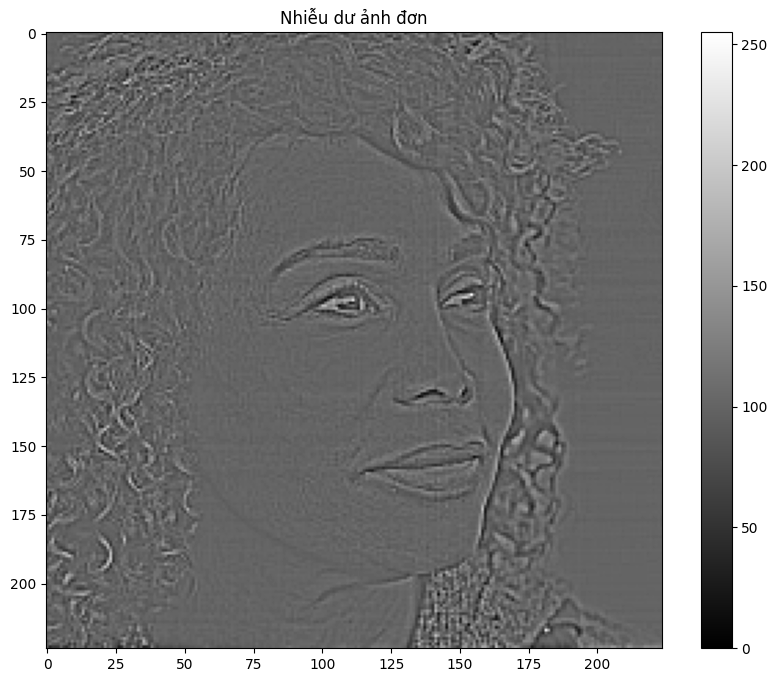

In [43]:
image_test = Image.open("/kaggle/input/check-myself/tht2.jpg")
image_array = np.array(image_test)

noise = extract_single(image_array, sigma=1.5)

noise_normalized = ((noise - noise.min()) / (noise.max() - noise.min()) * 255).astype(np.uint8)

plt.figure(figsize=(10, 8))
plt.imshow(noise_normalized, cmap='gray')
plt.colorbar()
plt.title('Nhiễu dư ảnh đơn')
plt.show()

In [10]:
# def extract_prnu(images, sigma = 1.5):
#     all_noises = []

#     for img in tqdm(images, desc="Đang tách nhiễu dư"):
#         noise = extract_single(img, sigma)
#         all_noises.append(noise)

#     noise_stack = np.stack(all_noises, axis = 0)
#     prnu = np.median(noise_stack, axis = 0)
#     return prnu

In [11]:
# folder_path = '/kaggle/input/ai-real-images/dataset/Real/Green Apples'
# images_files = []
# for f in os.listdir(folder_path):
#     if f.endswith(('.jpg', '.jpeg', '.png', '.tif', '.JPG', '.JPEG', '.PNG', '.TIF')):
#         full_path = os.path.join(folder_path, f)
#         images_files.append(full_path)

# image_size = (256,256)
# images = []
# for img_path in images_files:
#     try:
#         img_temp = Image.open(img_path)
#         resized_img = img_temp.resize(image_size)
#         img = np.array(resized_img)
#         images.append(img)
#     except Exception as e:
#         print(f"Không thể mở ảnh: {img_path} - Lỗi: {e}")

# if images:
#     prnu = extract_prnu(images, sigma = 1.5)

#     np.save('prnu.npy', prnu)

#     normalized_prnu = (prnu - prnu.min()) / (prnu.max() - prnu.min())

#     plt.figure(figsize=(10, 8))
#     plt.imshow(normalized_prnu, cmap='gray')
#     plt.colorbar()
#     plt.title('PRNU của máy ảnh')
#     plt.show()
# else:
#     print(f"Không tìm thấy hoặc không thể tải bất kỳ ảnh nào từ thư mục: {folder_path}")

In [12]:
# # Reset output (dùng nếu cần thôi)
# !rm -rf noise_dataset/*
# !rm -rf __pycache__/
# !find . -name "*.npy" -delete

Đặc trưng phân tích miền tần số:

* ảnh thật được chụp có đặc trưng tần số cao thấp xen kẽ, sáng tối rõ ràng
* Ảnh AI thường được làm mượt -> có đặc trưng phổ giả tạo, có chủ đích, thiếu các vân đặc trưng

=> trích xuất đặc trưng entropy trong miền tần số

In [13]:
def freqq(noise):
    fft = np.fft.fft2(noise) #chuyen noise ve dang song o so phuc
    fft_shift = np.fft.fftshift(fft)
    mag = np.abs(fft_shift)
    mag_log = np.log1p(mag)
    mag_norm = (mag_log - np.min(mag_log)) / (np.max(mag_log) - np.min(mag_log))
    return mag_norm

In [14]:
# @tf.function
# def freqq(noise: tf.Tensor):
#     noise_float32 = tf.cast(noise, dtype=tf.float32)
#     fft = tf.signal.fft2d(tf.cast(noise_float32, dtype=tf.complex64))
#     fft_shift = tf.signal.fftshift(fft)
#     mag = tf.abs(fft_shift)
#     mag_log = tf.math.log1p(mag)
#     mag_log_min = tf.reduce_min(mag_log)
#     mag_log_max = tf.reduce_max(mag_log)

#     denominator = mag_log_max - mag_log_min
#     mag_norm = tf.where(
#         tf.math.less_equal(denominator, 1e-8),
#         tf.zeros_like(mag_log),
#         (mag_log - mag_log_min) / denominator
#     )
#     return tf.cast(mag_norm, dtype=tf.float32)

Đặc trưng đồng nhất nhiễu:
* ảnh thật, nhiễu phân bố đều
* ảnh ai nhiễu nhân tạo phân bố ko đều

=> sử dụng bản đồ nhất quán để bắt mức độ biến thiên của phân bố nhiễu. Nó soi xem từng khu vực nhỏ của ảnh nhiễu có ổn định hay bất thường so với toàn ảnh ko. Bất thường nhiều thì có thể là dấu hiệu của ảnh fake

In [15]:
def consis_map(noise, window_size):
    h, w = noise.shape
    heat_map = np.zeros_like(noise)
    glob_std = np.std(noise)

    for i in range(0, h-window_size, window_size//2): #buoc nhay nho
        for j in range(0, w-window_size, window_size//2):
            patch = noise[i:i+window_size, j:j+window_size]
            local_std = np.std(patch)
            consis =np.abs(local_std - glob_std) / (glob_std + 1e-8)
            heat_map[i:i+window_size, j:j+window_size] = consis
    heat_map = (heat_map - np.min(heat_map)) / (np.max(heat_map) - np.min(heat_map))
    return heat_map

In [16]:
# @tf.function
# def consis_map(noise: tf.Tensor, window_size: int, epsilon=1e-8):
#     noise = tf.cast(noise, dtype=tf.float32)
#     if tf.rank(noise) != 2:
#         raise ValueError("Input 'noise' phải là tensor 2D.")

#     h = tf.shape(noise)[0]
#     w = tf.shape(noise)[1]
#     glob_std = tf.math.reduce_std(noise)
#     noise_4d = noise[tf.newaxis, ..., tf.newaxis]
#     patch_size = [1, window_size, window_size, 1]
#     patch_strides = [1, window_size // 2, window_size // 2, 1]

#     patches = tf.image.extract_patches(
#         images=noise_4d,
#         sizes=patch_size,
#         strides=patch_strides,
#         rates=[1, 1, 1, 1],
#         padding='VALID'
#     )
#     local_std = tf.math.reduce_std(patches, axis=-1)
#     consis = tf.abs(local_std - glob_std) / (glob_std + epsilon)
#     consis_map_small = tf.squeeze(consis, axis=0)

#     heat_map_resized = tf.image.resize(
#         consis_map_small[..., tf.newaxis],
#         size=[h, w],
#         method=tf.image.ResizeMethod.BILINEAR
#     )
#     heat_map_resized = tf.squeeze(heat_map_resized, axis=-1)

#     heat_map_min = tf.reduce_min(heat_map_resized)
#     heat_map_max = tf.reduce_max(heat_map_resized)
#     denominator = heat_map_max - heat_map_min
#     heat_map_norm = tf.where(
#         tf.math.less_equal(denominator, epsilon),
#         tf.zeros_like(heat_map_resized),
#         (heat_map_resized - heat_map_min) / denominator
#     )

#     return tf.cast(heat_map_norm, dtype=tf.float32)

Tạo thư mục chứa noise ảnh và gán nhãn noise

* 1: là ảnh thật
* 0: là ảnh AI


In [20]:
dataset_path = "/kaggle/input/ai-generated-images-vs-real-images/test"
X_noise = []
X_fft = []
X_consis = []
y = []

def xu_li_img_np(img_path, label, sigma_val=1.5, window_size_val=8):
    try:
        img = np.array(Image.open(img_path))
        noise = extract_single(img, sigma=sigma_val)
        fft = freqq(noise)
        consis = consis_map(noise, window_size=window_size_val)
        return noise, fft, consis, label

    except Exception as e:
        print(f"Lỗi khi xử lý {img_path}: {e}")
        return None

ai_path = os.path.join(dataset_path, "fake")
ai_images = [
    os.path.join(ai_path, f)
    for f in os.listdir(ai_path)
    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif'))
]

random.shuffle(ai_images)
selected_ai_images = ai_images[:2000]

print(f"Bắt đầu xử lý {len(selected_ai_images)} ảnh AI...")
for img_path in tqdm(selected_ai_images, desc="Đang xử lý ảnh AI"):
    result = xu_li_img_np(img_path, label=0)
    if result is not None:
        noise, fft, consis, label = result
        X_noise.append(noise[..., np.newaxis])
        X_fft.append(fft[..., np.newaxis])
        X_consis.append(consis[..., np.newaxis])
        y.append(label)

real_path = os.path.join(dataset_path, "real")
real_images = [
    os.path.join(real_path, f)
    for f in os.listdir(real_path)
    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif'))
]

random.shuffle(real_images)
selected_real_images = real_images[:2000]

print(f"\nBắt đầu xử lý {len(selected_real_images)} ảnh thật...")
for img_path in tqdm(selected_real_images, desc="Đang xử lý ảnh thật"):
    result = xu_li_img_np(img_path, label=1)
    if result is not None:
        noise, fft, consis, label = result
        X_noise.append(noise[..., np.newaxis])
        X_fft.append(fft[..., np.newaxis])
        X_consis.append(consis[..., np.newaxis])
        y.append(label)

print(f"\nXử lý hoàn tất!")
print(f"Số lượng mẫu đã xử lý thành công: {len(y)}")
if y:
    print("Shape của noise mẫu đầu tiên:", X_noise[0].shape)
    print("Shape của fft mẫu đầu tiên:", X_fft[0].shape)
    print("Shape của consis mẫu đầu tiên:", X_consis[0].shape)

Bắt đầu xử lý 2000 ảnh AI...


Đang xử lý ảnh AI: 100%|██████████| 2000/2000 [24:29<00:00,  1.36it/s] 



Bắt đầu xử lý 2000 ảnh thật...


Đang xử lý ảnh thật:  48%|████▊     | 964/2000 [54:00<1:02:25,  3.62s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (143040000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Đang xử lý ảnh thật:  63%|██████▎   | 1259/2000 [1:12:12<34:58,  2.83s/it]  

Lỗi khi xử lý /kaggle/input/ai-generated-images-vs-real-images/test/real/5197.jpg: image file is truncated (6 bytes not processed)


Đang xử lý ảnh thật:  71%|███████   | 1421/2000 [1:21:34<13:03,  1.35s/it]  

Lỗi khi xử lý /kaggle/input/ai-generated-images-vs-real-images/test/real/5325.jpg: image file is truncated (3 bytes not processed)


Đang xử lý ảnh thật: 100%|██████████| 2000/2000 [1:51:49<00:00,  3.35s/it]  


Xử lý hoàn tất!
Số lượng mẫu đã xử lý thành công: 3998
Shape của noise mẫu đầu tiên: (224, 224, 1)
Shape của fft mẫu đầu tiên: (224, 224, 1)
Shape của consis mẫu đầu tiên: (224, 224, 1)


In [ ]:
# dataset_path = "/kaggle/input/ai-generated-images-vs-real-images/test"
# IMG_HEIGHT = 224
# IMG_WIDTH = 224
# NOISE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)
# SIGMA = 1.5
# WINDOW_SIZE = 8
# BATCH_SIZE = 32
# BUFFER_SIZE = 1000

# ai_path = os.path.join(dataset_path, "fake")
# real_path = os.path.join(dataset_path, "real")

# ai_images = [os.path.join(ai_path, f) for f in os.listdir(ai_path)
#              if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif'))]
# real_images = [os.path.join(real_path, f) for f in os.listdir(real_path)
#                if f.lower().endswith(('.jpg', '.jpeg', '.png','.tif'))]

# # Giới hạn số lượng ảnh (nếu cần, giống code gốc)
# # random.shuffle(ai_images)
# # random.shuffle(real_images)
# # selected_ai_images = ai_images[:2000]
# # selected_real_images = real_images[:2000]

# all_image_paths = ai_images + real_images
# all_labels = [0] * len(ai_images) + [1] * len(real_images)

# temp = list(zip(all_image_paths, all_labels))
# random.shuffle(temp)
# all_image_paths, all_labels = zip(*temp)
# all_image_paths = list(all_image_paths)
# all_labels = list(all_labels)

# print(f"Tổng số ảnh: {len(all_image_paths)}")
# print(f"Phân bố nhãn (ước lượng): AI={all_labels.count(0)}, Real={all_labels.count(1)}")

# def load_and_decode_image(image_path):
#     img_bytes = tf.io.read_file(image_path)
#     img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False, dtype=tf.float32)
#     return img

# def preprocess_image(image_tensor, label):
#     noise = extract_single(image_tensor, sigma=SIGMA, noise_shape=NOISE_SHAPE)
#     fft = freqq(noise)
#     consis = consis_map(noise, window_size=WINDOW_SIZE)

#     noise = noise[..., tf.newaxis]
#     fft = fft[..., tf.newaxis]
#     consis = consis[..., tf.newaxis]

#     return (noise, fft, consis), label

# path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
# label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_labels, tf.int64))
# image_label_ds = tf.data.Dataset.zip((path_ds, label_ds))

# AUTOTUNE = tf.data.AUTOTUNE

# full_dataset = image_label_ds.map(
#     lambda path, label: (load_and_decode_image(path), label),
#     num_parallel_calls=AUTOTUNE
# )


# processed_dataset = full_dataset.map(
#     preprocess_image,
#     num_parallel_calls=AUTOTUNE
# )


# dataset_size = len(all_image_paths)
# train_size = int(0.7 * dataset_size)
# val_size = int(0.15 * dataset_size)

# image_label_ds = image_label_ds.shuffle(BUFFER_SIZE, reshuffle_each_iteration=False)

# train_ds_paths_labels = image_label_ds.take(train_size)
# remaining_ds = image_label_ds.skip(train_size)
# val_ds_paths_labels = remaining_ds.take(val_size)
# test_ds_paths_labels = remaining_ds.skip(val_size)

# train_dataset = train_ds_paths_labels.map(
#     lambda path, label: (load_and_decode_image(path), label), num_parallel_calls=AUTOTUNE
# ).map(
#     preprocess_image, num_parallel_calls=AUTOTUNE
# ).cache().shuffle(BUFFER_SIZE // 10).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# val_dataset = val_ds_paths_labels.map(
#     lambda path, label: (load_and_decode_image(path), label), num_parallel_calls=AUTOTUNE
# ).map(
#     preprocess_image, num_parallel_calls=AUTOTUNE
# ).cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# test_dataset = test_ds_paths_labels.map(
#     lambda path, label: (load_and_decode_image(path), label), num_parallel_calls=AUTOTUNE
# ).map(
#     preprocess_image, num_parallel_calls=AUTOTUNE
# ).cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)


# print("Pipeline train dataset:", train_dataset)
# print("Pipeline validation dataset:", val_dataset)
# print("Pipeline test dataset:", test_dataset)

# # --- Kiểm tra một batch (Optional) ---
# for features, labels in train_dataset.take(1):
#     noise_batch, fft_batch, consis_batch = features
#     print("Kích thước tập noise:", noise_batch.shape)
#     print("Kích thước tập FFT:", fft_batch.shape)
#     print("Kích thước consis map:", consis_batch.shape)
#     print("kích thước tập label:", labels.shape)
#     # Có thể hiển thị một mẫu nếu muốn
#     plt.imshow(noise_batch[0, :, :, 0], cmap='gray')
#     plt.title(f"Label: {labels[0].numpy()}")
#     plt.show()

In [21]:
X_noise = np.array(X_noise)
X_fft = np.array(X_fft)
X_consis = np.array(X_consis)
y = np.array(y)

X_noise_train, X_noise_temp, X_fft_train, X_fft_temp, X_consis_train, X_consis_temp, y_train, y_temp = train_test_split(
    X_noise, X_fft, X_consis, y, test_size=0.3, stratify=y)

X_noise_val, X_noise_test, X_fft_val, X_fft_test, X_consis_val, X_consis_test, y_val, y_test = train_test_split(
    X_noise_temp, X_fft_temp, X_consis_temp, y_temp, test_size=0.5, stratify=y_temp)

print(f"kích thước tập noise: {X_noise.shape}")
print(f"kích thước tập fft: {X_fft.shape}")
print(f"kích thước consis map: {X_consis.shape}")
print(f"kích thước tập label: {y.shape}")

print(f"phân bố nhãn train: {np.bincount(y_train)}")
print(f"phân bố nhãn val: {np.bincount(y_val)}")
print(f"phân bố nhãn test: {np.bincount(y_test)}")


np.save('/kaggle/working/X_noise_train.npy', X_noise_train)
np.save('/kaggle/working/X_noise_val.npy', X_noise_val)
np.save('/kaggle/working/X_noise_test.npy', X_noise_test)

np.save('/kaggle/working/X_fft_train.npy', X_fft_train)
np.save('/kaggle/working/X_fft_val.npy', X_fft_val)
np.save('/kaggle/working/X_fft_test.npy', X_fft_test)

np.save('/kaggle/working/X_consis_train.npy', X_consis_train)
np.save('/kaggle/working/X_consis_val.npy', X_consis_val)
np.save('/kaggle/working/X_consis_test.npy', X_consis_test)

np.save('/kaggle/working/y_train.npy', y_train)
np.save('/kaggle/working/y_val.npy', y_val)
np.save('/kaggle/working/y_test.npy', y_test)

print("Đã lưu dữ liệu thành công!")


kích thước tập noise: (3998, 224, 224, 1)
kích thước tập fft: (3998, 224, 224, 1)
kích thước consis map: (3998, 224, 224, 1)
kích thước tập label: (3998,)
phân bố nhãn train: [1400 1398]
phân bố nhãn val: [300 300]
phân bố nhãn test: [300 300]
Đã lưu dữ liệu thành công!


In [28]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Activation, LeakyReLU

def build_cnn():
    ip = Input(shape=(224, 224, 1))
    x = Conv2D(64, (3, 3), padding='same')(ip)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling2D((2, 2))(x)
    
    shortcut = Conv2D(128, (1, 1), padding='same')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = LeakyReLU(0.1)(x)
    x = MaxPooling2D((2, 2))(x)
    
    shortcut = Conv2D(256, (1, 1), padding='same')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = LeakyReLU(0.1)(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = GlobalAveragePooling2D()(x)
    
    fft_in = Input(shape=(224, 224, 1))
    fft_op = Conv2D(48, (3, 3), padding='same')(fft_in)
    fft_op = BatchNormalization()(fft_op)
    fft_op = LeakyReLU(0.1)(fft_op)
    fft_op = MaxPooling2D((2, 2))(fft_op)
    
    fft_op = Conv2D(96, (3, 3), padding='same')(fft_op)
    fft_op = BatchNormalization()(fft_op)
    fft_op = LeakyReLU(0.1)(fft_op)
    fft_op = MaxPooling2D((2, 2))(fft_op)
    
    fft_op = GlobalAveragePooling2D()(fft_op)
    
    cm_in = Input(shape=(224, 224, 1))
    cm_op = Conv2D(48, (3, 3), padding='same')(cm_in)
    cm_op = BatchNormalization()(cm_op)
    cm_op = LeakyReLU(0.1)(cm_op)
    cm_op = MaxPooling2D((2, 2))(cm_op)
    
    cm_op = Conv2D(96, (3, 3), padding='same')(cm_op)
    cm_op = BatchNormalization()(cm_op)
    cm_op = LeakyReLU(0.1)(cm_op)
    cm_op = MaxPooling2D((2, 2))(cm_op)
    
    cm_op = GlobalAveragePooling2D()(cm_op)
    
    merged = Concatenate()([x, fft_op, cm_op])
    merged = Dense(512, activation=None)(merged)
    merged = BatchNormalization()(merged)
    merged = LeakyReLU(0.1)(merged)
    merged = Dropout(0.4)(merged)
    
    merged = Dense(256)(merged)
    merged = BatchNormalization()(merged)
    merged = LeakyReLU(0.1)(merged)
    merged = Dropout(0.3)(merged)
    
    op = Dense(1, activation='sigmoid')(merged)
    
    model = Model([ip, fft_in, cm_in], op)
    
    return model

In [29]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

pos_count = np.sum(y_train)
neg_count = len(y_train) - pos_count
total = len(y_train)

weight_for_0 = (1 / neg_count) * (total / 2)
weight_for_1 = (1 / pos_count) * (total / 2)
class_weights = {0: weight_for_0, 1: weight_for_1}

optimizer = Adam(
    learning_rate=0.0005,
    clipnorm=1.0,
    beta_1=0.9,
    beta_2=0.999
)

model = build_cnn()
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

history = model.fit(
    [X_noise_train, X_fft_train, X_consis_train],
    y_train,
    validation_data=([X_noise_val, X_fft_val, X_consis_val], y_val),
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    class_weight=class_weights,
    shuffle=True
)

Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.6710 - auc: 0.7244 - loss: 0.6588 - precision: 0.6685 - recall: 0.6629
Epoch 1: val_accuracy improved from -inf to 0.34833, saving model to best_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 126s 475ms/step - accuracy: 0.6710 - auc: 0.7244 - loss: 0.6587 - precision: 0.6686 - recall: 0.6628 - val_accuracy: 0.3483 - val_auc: 0.3245 - val_loss: 0.9504 - val_precision: 0.3704 - val_recall: 0.4333 - learning_rate: 5.0000e-04
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.7136 - auc: 0.7915 - loss: 0.5618 - precision: 0.7221 - recall: 0.7041
Epoch 2: val_accuracy improved from 0.34833 to 0.38500, saving model to best_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 48s 274ms/step - accuracy: 0.7137 - auc: 0.7915 - loss: 0.5618 - precision: 0.7222 - recall: 0.7042 - val_accuracy: 0.3850 - val_auc: 0.3663 - val_loss: 1.4062 - val_precision: 0.3932 - val_recall: 0.4233 - learning_rate: 5.0000e-04
Epoch 3/100
175/175 

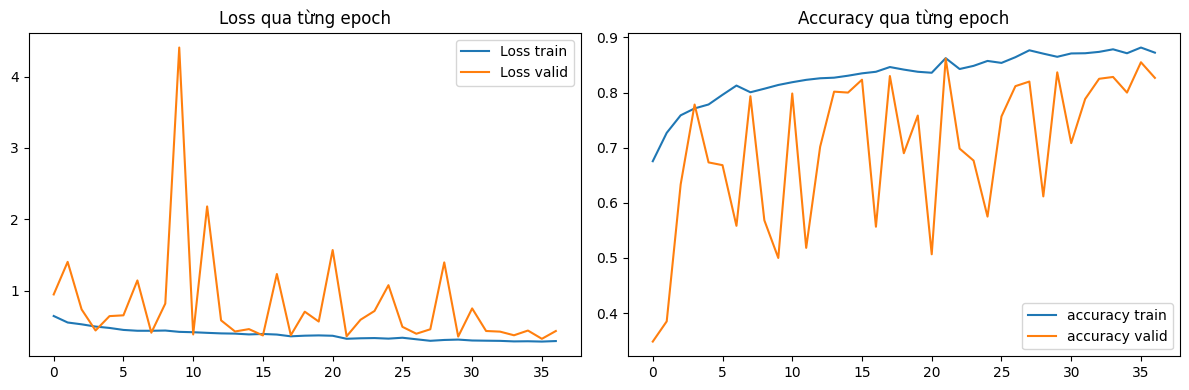

In [30]:
plt.figure(figsize=(12, 4))

# Vẽ loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss train')
plt.plot(history.history['val_loss'], label='Loss valid')
plt.title('Loss qua từng epoch')
plt.legend()

# Vẽ accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy train')
plt.plot(history.history['val_accuracy'], label='accuracy valid')
plt.title('Accuracy qua từng epoch')
plt.legend()

plt.tight_layout()
plt.show()

import pandas as pd
pd.DataFrame(history.history).to_csv('training_history.csv')

In [31]:
model.save('prnu_model.h5')

import json
paras = {
    'noise_shape': (224, 224),
    'sigma': 1.5
}

with open('/kaggle/working/paras_model.json', 'w') as f:
    json.dump(paras, f)

In [32]:
from tensorflow.keras.models import load_model
def load_model_paras(model_path, paras_path):
    model = load_model(model_path)

    with open(paras_path, 'r') as f:
        paras = json.load(f)

    return model, paras

In [34]:
def predict_img(img_array, model, paras):
    noise = extract_single(img_array, sigma=paras['sigma'])
    
    from skimage.transform import resize
    noise = resize(noise, paras['noise_shape'], preserve_range=True, anti_aliasing=True)
    
    fft = freqq(noise)
    consis = consis_map(noise, window_size=8)
    
    noise = noise.reshape(1, paras['noise_shape'][0], paras['noise_shape'][1], 1)
    fft = fft.reshape(1, paras['noise_shape'][0], paras['noise_shape'][1], 1)
    consis = consis.reshape(1, paras['noise_shape'][0], paras['noise_shape'][1], 1)
    
    prediction = model.predict([noise, fft, consis])[0][0]
    
    result = "ảnh thật đó!" if prediction >= 0.5 else "ảnh AI rồi!"
    confidence = prediction if prediction >= 0.5 else 1 - prediction
    
    return result, confidence

In [45]:
model, paras = load_model_paras('/kaggle/working/prnu_model.h5', 
                               '/kaggle/working/paras_model.json')

img_path = '/kaggle/input/check-myself/tht2.jpg'
img = np.array(Image.open(img_path))

result, confidence = predict_img(img, model, paras)

print(f"Ảnh này là: {result}")
print(f"Độ tin cậy: {confidence*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Ảnh này là: ảnh thật đó!
Độ tin cậy: 89.53%
